## Setup & packages

1. packs

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt  # one of the best graphics library for python
import os
import time
from tqdm import tqdm # !pip install tqdm

from typing import Iterable
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms
import torchvision.models as models
import torchvision

from PIL import Image

2. Mount google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


3. State configurations

In [16]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 42 
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    alpha = 0.00001 # content loss weight : style loss weight
    max_iter = 500
    learning_rate: float = 0.01  
    data_root: str = "/content/drive/MyDrive/Colab Notebooks/style_blending" 
    content_path = os.path.join(data_root,"images","C_DC2.png") 
    style_path = os.path.join(data_root,"images","Leonid_Afremov6.jpeg") 
    transform=transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])   # PILToTensor give [0,255] values
    
    if torch.cuda.is_available():
        device: str = "cuda"
    else:
        device: str = "cpu"
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

## Read data

1. load content and style image

In [4]:
# given config, load content/style image
# current support: .png, .jpg, .jpeg, check when types not included
def load_img(config:TrainingConfiguration):

  content_img = Image.open(config.content_path)
  style_img = Image.open(config.style_path)

  # content_img
  if config.content_path[-3:]=="png":
    content_img = content_img.convert("RGB") # avoid RGBA 4 channels but make sure with 3 channels
    content_img = config.transform(content_img) # output: size 224*224, values [0,1], normalized by mean & std
  elif config.content_path[-3:]=="jpg" or config.content_path[-4:]=="jpeg":
    content_img = config.transform(content_img)
  else:
    print("Warning: please check image type!")
  
  # style_img
  if config.style_path[-3:]=="png":
    style_img.convert("RGB") 
    style_img = config.transform(style_img)
  elif config.style_path[-3:]=="jpg" or config.style_path[-4:]=="jpeg":
    style_img = config.transform(style_img)
  else:
    print("Warning: please check image type!") 
  
  # output are 224*224, [0,1], RGB -> normalized by mean/std values
  return content_img, style_img

2. load, show inpute images

The shape of content image is torch.Size([3, 224, 224]), min: -1.9481792449951172, max: 2.248908281326294 
The shape of style image is torch.Size([3, 224, 224]), min: -2.0494048595428467, max: 2.5702831745147705 


Text(0.5, 1.0, 'style image')

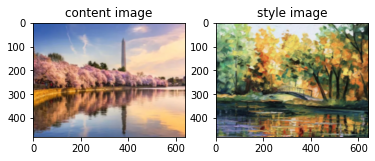

In [5]:
# convert content_img, style_img to [480,640], value [0,255]
def convert_transforms(img_transformed):
  inverse_transform=transforms.Compose([transforms.Resize((480,640)),transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))])  
  img = inverse_transform(img_transformed)
  # output are 480*640, [0,255], RGB values
  return img


# load content_image and style_image and show
content_image,style_image = load_img(TrainingConfiguration)
print("The shape of content image is {}, min: {}, max: {} \nThe shape of style image is {}, min: {}, max: {} ".format(content_image.shape, torch.min(content_image), torch.max(content_image),style_image.shape, torch.min(style_image), torch.max(style_image)))
plt.subplot(1,2,1)  
plt.imshow(convert_transforms(content_image).permute(1,2,0)) #content_image is (c,h,w), but imshow takes (h,w,c)
plt.title("content image")
plt.subplot(1,2,2)  
plt.imshow(convert_transforms(style_image).permute(1,2,0)) #content_image is (c,h,w), but imshow takes (h,w,c)
plt.title("style image")



## Loss functions

1. content_loss 

In [6]:
class content_loss(nn.Module):
  def __init__(self, target_features):
    super(content_loss,self).__init__()
    self.target_features = target_features.detach()
  def cal_content_loss(self, estimate_features):
    self.loss = F.mse_loss(estimate_features,self.target_features)
    return self.loss

2. style loss

In [7]:
def gram_matrix(features):
  c,n,h,w = features.size()
  features = features.view(c*n,h*w)
  G = torch.mm(features, features.t()).div(c*n*h*w)
  return G

class style_loss(nn.Module):
  def __init__(self, target_features):
    super(style_loss,self).__init__()
    self.texture = gram_matrix(target_features).detach()
  def cal_style_loss(self, estimate_features):
    texture_est = gram_matrix(estimate_features)
    self.loss = F.mse_loss(texture_est,self.texture)
    return self.loss

## Transfering model

In [8]:
class ModelConfiguration:
    '''
    Describes configuration of the training process
    '''
    model_name = "vgg19" # if you want to change model, you should change model_config & get_model
    normalization_mean = torch.tensor([0.485, 0.456, 0.406])
    normalization_std = torch.tensor([0.229, 0.224, 0.225])
    content_weight = [1]
    style_weight = [0.05,0.1,0.15,0.25,0.35]
    content_layers = ["conv4_2"]
    style_layers = ["conv1_1","conv2_1","conv3_1","conv4_1","conv5_1"]

In [9]:
class getmodel(nn.Module):
  def __init__(self, sequential):
      super().__init__()
      self.body = sequential
  def forward(self, x):
      x = self.body(x)
      return x 


def get_model(model_config:ModelConfiguration, config: TrainingConfiguration, content_input: content_image, style_input: style_image):

  vgg19_model = models.vgg19(pretrained=True)
  vgg19_features = vgg19_model.features.to(config.device).eval()
  for param in vgg19_features.parameters():
    param.requires_grad_(requires_grad = False)
  m_sequential = nn.Sequential()

  content_layers = model_config.content_layers # list of layers' names that contribute to measure the content loss
  style_layers = model_config.style_layers # list of layers' names that contribute to measure the style loss
  content_losses = []
  style_losses = []

  i = 1
  jconv = 1
  jrelu = 1
  for layer in vgg19_features.children():
    if isinstance(layer, nn.Conv2d):
      layer_name = "conv" + str(i) + "_" + str(jconv)
      jconv+=1
    elif isinstance(layer, nn.ReLU):
      layer_name = "relu_" + str(i) + str(jrelu)
      jrelu+=1
    elif isinstance(layer, nn.MaxPool2d):
      layer_name = "maxpool_" + str(i)
      i+=1
      jconv =1
      jrelu =1
    else:
      raise RuntimeError("Unrecognized layer named {}".format(layer.__class__.__name__))
    m_sequential.add_module(layer_name,layer)
    if layer_name in content_layers:
      modeleval = getmodel(m_sequential)
      c_features = modeleval(content_input).detach()
      print("extraced content feature of content image is of size: ", layer_name,c_features.shape)
      c_loss = content_loss(c_features)
      content_losses.append(c_loss)
    if layer_name in style_layers:
      modeleval = getmodel(m_sequential)
      s_features = modeleval(style_input).detach()
      print("extracted style feature of style image is of size: ", layer_name,s_features.shape)
      s_loss = style_loss(s_features)
      style_losses.append(s_loss)
    if len(content_losses)==len(content_layers) and len(style_losses)==len(style_layers):
      break
  model = getmodel(m_sequential)
  return model, content_losses, style_losses

## Optimization & training

In [17]:
# normalize the feeds (content_input, style_input) for get_model
config = TrainingConfiguration()
model_config = ModelConfiguration()
content_input = torch.unsqueeze(content_image, 0).to(config.device).detach()
style_input = torch.unsqueeze(style_image, 0).to(config.device).detach()
# initialize the output and set requires_grad = True
output_img = content_input.clone().detach()
output_img.requires_grad_(requires_grad=True)
print("make sure the requires_grad of output_img is True: ", output_img.requires_grad)


make sure the requires_grad of output_img is True:  True


In [18]:
model, content_losses, style_losses = get_model(ModelConfiguration(), TrainingConfiguration(), content_input, style_input)

extracted style feature of style image is of size:  conv1_1 torch.Size([1, 64, 224, 224])
extracted style feature of style image is of size:  conv2_1 torch.Size([1, 128, 112, 112])
extracted style feature of style image is of size:  conv3_1 torch.Size([1, 256, 56, 56])
extracted style feature of style image is of size:  conv4_1 torch.Size([1, 512, 28, 28])
extraced content feature of content image is of size:  conv4_2 torch.Size([1, 512, 28, 28])
extracted style feature of style image is of size:  conv5_1 torch.Size([1, 512, 14, 14])


In [19]:
optimizer = optim.Adam([output_img],lr = config.learning_rate, betas = (0.99,0.995))
loss = torch.tensor(0.0, requires_grad=True)
for i in tqdm(range(config.max_iter)):
  optimizer.zero_grad()
  for idx, target_name in enumerate(model_config.content_layers):
    curr_model = nn.Sequential()
    for layer_name, layer in model.body.named_children():
      curr_model.add_module(layer_name,layer)
      if layer_name == target_name:
        modeleval = getmodel(curr_model)
        break
    cfeature = modeleval(output_img)
    closs = content_losses[idx]
    loss = loss + config.alpha*closs.cal_content_loss(cfeature)
  for idx, target_name in enumerate(model_config.style_layers):
    curr_model = nn.Sequential()
    for layer_name, layer in model.body.named_children():
      curr_model.add_module(layer_name,layer)
      if layer_name == target_name:
        modeleval = getmodel(curr_model)
        break
    sfeature = modeleval(output_img)
    sloss = style_losses[idx]
    loss = loss + sloss.cal_style_loss(sfeature)
  loss.backward(retain_graph=True)
  # print(i, torch.norm(output_img.grad),loss)
  optimizer.step()
  loss = 0.0

100%|██████████| 500/500 [00:27<00:00, 18.34it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


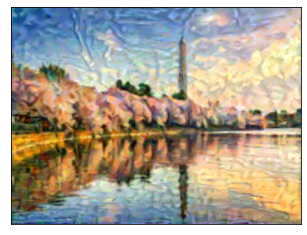

In [20]:
output_img.clamp(0,1)
output = output_img.squeeze(0).detach()
result = convert_transforms(output.cpu())

# show result
fig = plt.imshow(result.permute(1,2,0))
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

# # # show result and save output image to drive
data_root = "/content/drive/MyDrive/Colab Notebooks/style_blending" 
result_path = os.path.join(data_root,"images","result.png")
plt.imshow(result.permute(1,2,0))
plt.savefig(result_path);